# Import original MNIST  and Lower-Resolution Cifar10

In [31]:
from keras.datasets import cifar10
from keras.layers import Reshape,Dense
import numpy as np
from keras.layers import UpSampling2D,MaxPool2D,Conv2D,Activation,Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy import ndimage as nd
import myplot
from skimage.measure import compare_psnr,compare_ssim



In [2]:
data = cifar10.load_data()
Original_image = data[0][0]
Original_test = data[1][0]
down=np.load('LR_cifar10.npz')
LR_mnist=down['train_by2']
test_image=down['test_by2']

In [3]:
Original_image.shape

(50000, 32, 32, 3)

In [4]:
#Original_image = np.reshape(Original_image,(Original_image.shape[0],Original_image.shape[1],Original_image.shape[2],1))
print 'shape of original image is %d x %d  x%d  x%d ' %Original_image.shape
#LR_mnist = np.reshape(LR_mnist,(LR_mnist.shape[0],LR_mnist.shape[1],LR_mnist.shape[2],1))
print 'shape of downsample image is  %d x %d  x%d  x%d  ' %LR_mnist.shape 

shape of original image is 50000 x 32  x32  x3 
shape of downsample image is  50000 x 16  x16  x3  


# Traditional method of recover image from low resolution 

imresize support a lot of image Interpolation methods there I examed 5 of them. 
They are:  
- nearest 
- lanczors
- bilinear 
- cubic 
- bicubic 

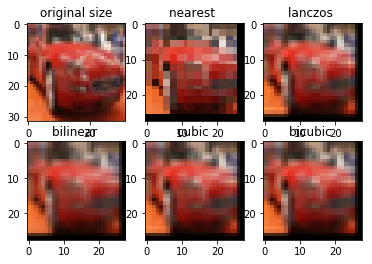

In [5]:
myplot.plot_comparison(Original_image[5],LR_mnist[5])

# The input is the half-resolution image , the output is the original image

Before generate the model. It is very important to normalise the image . 

The original value of image is between 0 and 255, I will make it between -1 and 1. 


In [6]:
LR_mnist = (LR_mnist-127.5)/127.5
Original_image = (Original_image-127.5)/127.5
Original_test = (Original_test-127.5)/127.5
test_image= (test_image-127.5)/127.5

print 'Max of LR_mnist is %f, Min of LR_mnist is %f' %(LR_mnist.max() ,LR_mnist.min() )
print 'Max of Original_image is %f, Min of Original_image is %f' %(Original_image.max() ,Original_image.min() )


Max of LR_mnist is 1.000000, Min of LR_mnist is -1.000000
Max of Original_image is 1.000000, Min of Original_image is -1.000000


In [7]:
Original_image.shape

(50000, 32, 32, 3)

In [32]:
G=Sequential()

G.add(UpSampling2D(size=(2,2),input_shape=LR_mnist[0].shape))

G.add(Conv2D(64,(9,9),padding='same'))
G.add(Activation('relu'))
#G.add(Conv2D(16,(5,5),padding='same'))
#G.add(Dropout(0.5))

#G.add(Activation('relu')) 
G.add(Conv2D(32,(1,1),padding='same'))

G.add(Activation('relu'))
# G.add(BatchNormalization())
G.add(Conv2D(3,(5,5),padding='same'))


G.summary()

G.compile(loss='mse',optimizer=Adam(lr=1e-3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_2 (UpSampling2 (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        15616     
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 3)         2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [33]:
G.fit(x=LR_mnist,y=Original_image,batch_size=100,epochs=3)

Epoch 1/3
50000/50000 [==============================] - 22s - loss: 0.0289     

# Benchmark 

In [34]:
def psnr(Original_test,test_image,interpolation):
    psnr_value = []
    for O_image,SR_image in zip(Original_test,test_image):
        imrecov = imresize(SR_image,size=(32,32,3),interp=interpolation)
        psnr_value.append(compare_psnr(O_image,imrecov))
        return np.array(psnr_value).mean() 

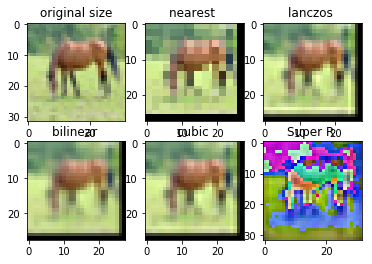

In [37]:

#test_image_1=np.reshape(test_image,(test_image.shape[0],test_image.shape[1],test_image.shape[2],3))
test_image_1=test_image
pred_img= G.predict(x=test_image_1)

#Original_test=(Original_test*127.5)+127.5
#pred_img = (pred_img*127.5)+127.5
#test_image = (test_image*127.5)+ 127.5 
pred_img=pred_img
myplot.plot_3(Original_test[60],test_image[60],pred_img[60])
pred_img_3D=pred_img
 
#pred_img_3D = np.reshape(pred_img,(pred_img.shape[0],pred_img.shape[1],pred_img.shape[2]))


In [29]:
pred_img[:,:,0]=pred_img[:,:,0]/pred_img[:,:,0].max()
pred_img[:,:,1]=pred_img[:,:,1]/pred_img[:,:,1].max()
pred_img[:,:,2]=pred_img[:,:,2]/pred_img[:,:,2].max()

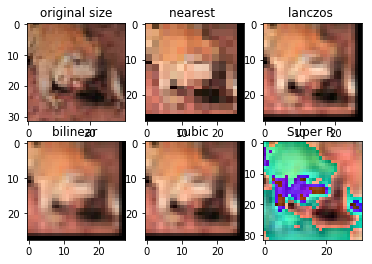

In [38]:

myplot.plot_3(Original_test[5],test_image[5],pred_img[5])

In [13]:
compare_psnr(Original_test,pred_img.astype('float64'))

ValueError: Input images must have the same dtype.

In [ ]:
Original_test.shape

In [ ]:
psnr(Original_test,test_image,'bicubic')